# Raport

## Import bibliotek

In [45]:
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sb
from sklearn.linear_model import LinearRegression

import pmdarima as pm

# 1. Wstęp - wizualizacja danych

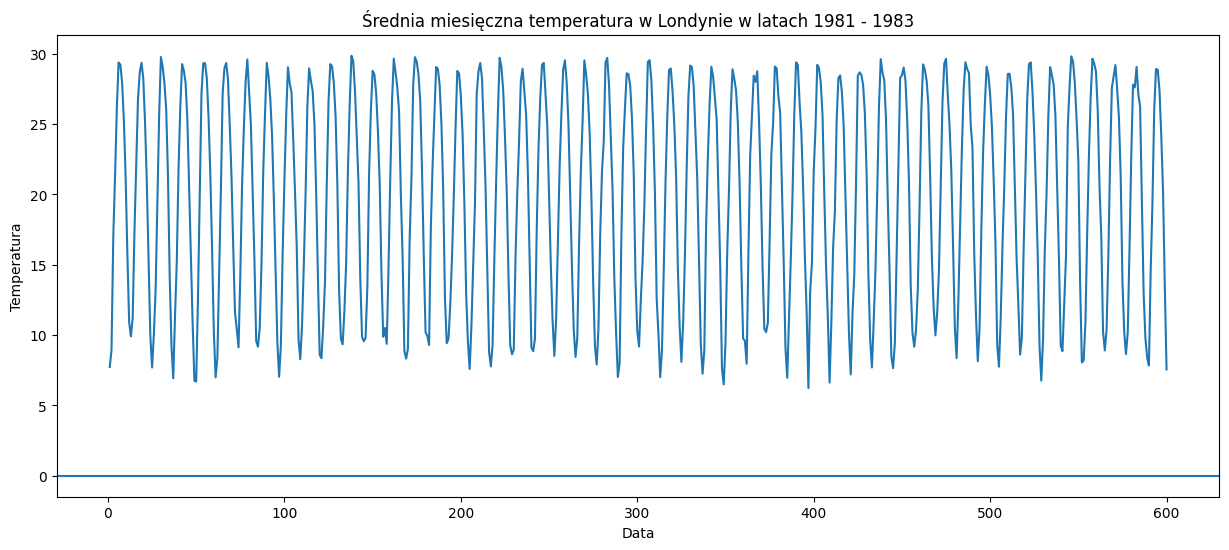

In [121]:
# Wczytaj dane z pliku CSV
dane_pogoda = pd.read_csv('Tempreture_1901_2016_Pakistan.csv')

# Załóżmy, że pierwsza kolumna to kolumna o indeksie 0, a czwarta kolumna to indeks 3
y = dane_pogoda.iloc[:, 0]  # Czwarta kolumna (indeks 3)

y = y[:(12*50)]
#print(len(y))
#y = y

#liczba_dni = dane_pogoda.iloc[:, 0].shape[0]
x = np.linspace(1, len(y), len(y))

# Tworzymy wykres
plt.figure(figsize=(15, 6))
plt.plot(x, y)

# Dodajemy tytuł i etykiety osi
plt.title('Średnia miesięczna temperatura w Londynie w latach 1981 - 1983')
plt.xlabel('Data')
plt.ylabel('Temperatura')


# Wyświetlamy wykres
plt.show()

C:\Users\Janek\AppData\Local\Temp\ipykernel_17324\4210348406.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  subset_y = y[start_index:end_index]


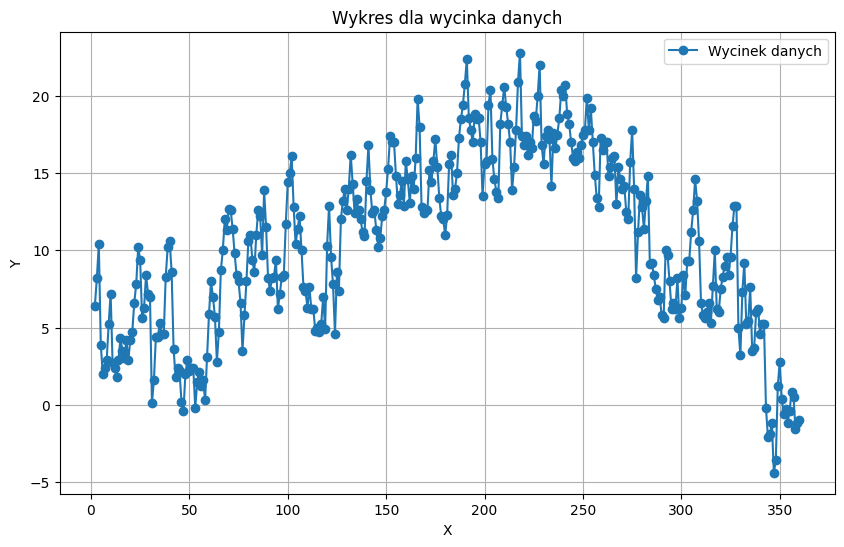

In [4]:
start_index = 1
end_index = 360

# Wybór wycinka danych
subset_x = x[start_index:end_index]
subset_y = y[start_index:end_index]

# Tworzenie wykresu dla wycinka
plt.figure(figsize=(10, 6))
plt.plot(subset_x, subset_y, marker='o', label='Wycinek danych')

# Opcjonalne dostosowanie wyglądu wykresu
plt.title('Wykres dla wycinka danych')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()

# Wyświetlanie wykresu
plt.show()

# 2. Przygotowanie danych do analizy

## 2.3  dekompozycja szeregu czasowego

### AFC surowe dane

In [89]:
h_max = 40
autokor_emp = acf(y, fft=True, nlags=h_max)

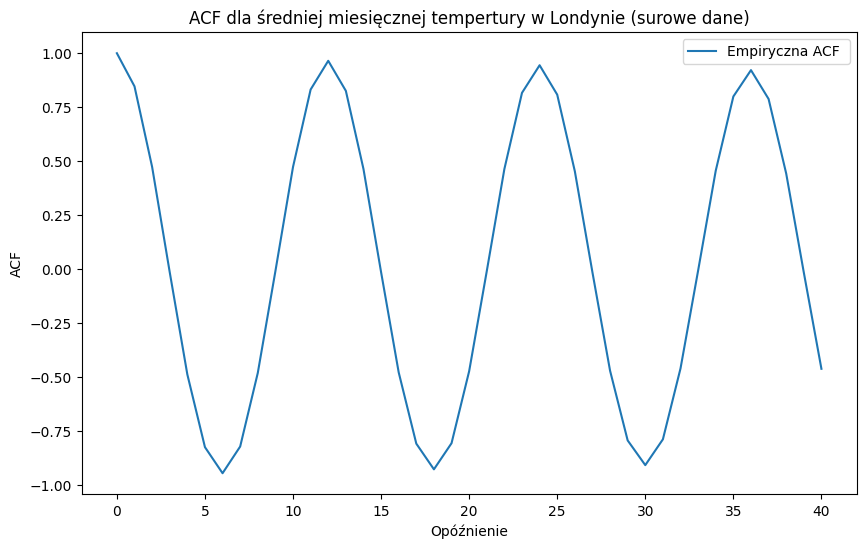

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(autokor_emp, label='Empiryczna ACF ')
plt.xlabel('Opóźnienie')
plt.ylabel('ACF')
plt.title('ACF dla średniej miesięcznej tempertury w Londynie (surowe dane)')
plt.legend()
plt.show()

### PAFC surowe dane

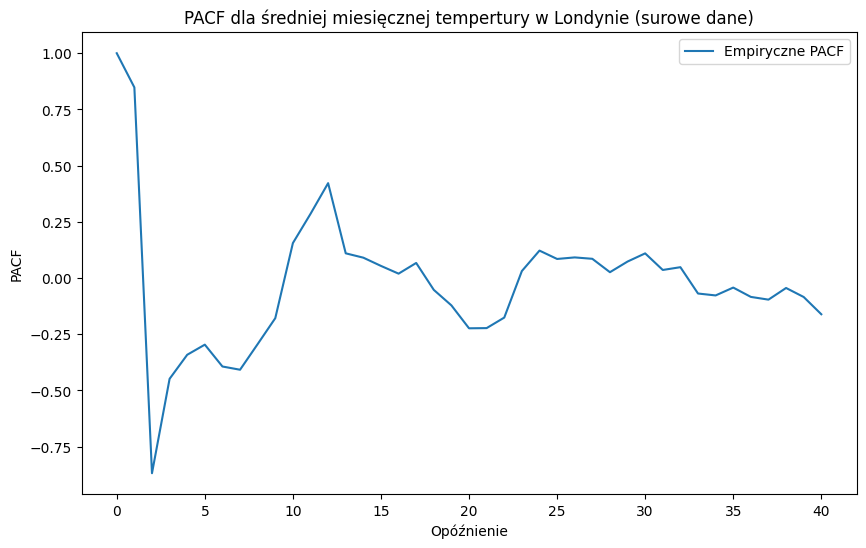

In [91]:
pacf_emp = pacf(y, nlags=h_max, method='yw')

plt.figure(figsize=(10, 6))
plt.plot(pacf_emp, label='Empiryczne PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('PACF')
plt.title('PACF dla średniej miesięcznej tempertury w Londynie (surowe dane)')
plt.legend()
plt.show()

### Identyfikacja trendów

### Pierwsz metoda

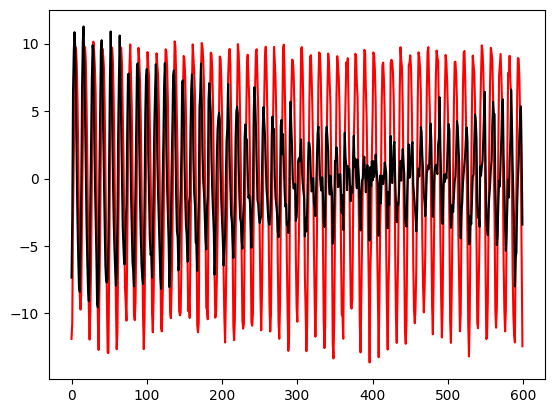

In [127]:
# to tutaj jest moją ostatnią desperacką próbą zrobienia dekompozycji "ręcznie"

linear_reg = LinearRegression()
linear_reg.fit(x.reshape(-1, 1), y)
trend_predicted = linear_reg.predict(x.reshape(-1, 1))

arma_trajectory_without_linear_trend = y - trend_predicted

# Usuwanie funkcji okresowej

def sine_func(n, A, omega):
    return A * np.sin(omega * n)

pzero = [max(y), 2 * np.pi /12]
params, _ = curve_fit(sine_func, x, arma_trajectory_without_linear_trend, p0=pzero)
fitted_sine_wave = sine_func(x, *params)

arma_trajectory_without_seasonal1 = arma_trajectory_without_linear_trend - fitted_sine_wave



plt.plot(arma_trajectory_without_linear_trend, c= 'r')
plt.plot(arma_trajectory_without_seasonal1, c = 'k')


# to jest kod od prowadzącej i nawet on nie jest w stanie poradzić sobie z dekompozycją angielskiej pogody xDDDDD

w sumie to nie wiem dlaczego to cholerstwo ma początek osi x w 700 a koniec w 1400

### Periodogram, bo czemu nie

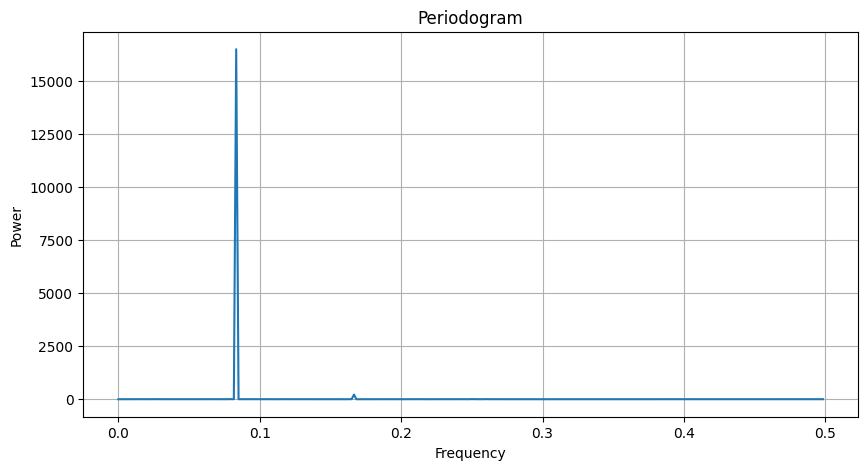

Top 5 Peaks (Frequency, Period):
Peak 1: -0.0833, -12.00
Peak 2: 0.0833, 12.00
Peak 3: 0.1667, 6.00
Peak 4: -0.1667, -6.00
Peak 5: 0.0167, 60.00
Peak 6: -0.0167, -60.00


In [93]:
# Periodogram

# z czasu przechodzimy na dziedzinę częstotliwości - to jest transformata Fouriera
periodogram = np.abs(np.fft.fft(arma_trajectory_without_linear_trend))**2 / len(arma_trajectory_without_linear_trend)
frequencies = np.fft.fftfreq(len(arma_trajectory_without_linear_trend))

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(arma_trajectory_without_linear_trend) // 2], periodogram[:len(arma_trajectory_without_linear_trend) // 2])
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

peak_indices = np.argsort(periodogram)[::-1][:6] 
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print("Top 5 Peaks (Frequency, Period):")
for i in range(len(peaks_frequency)):
    print(f"Peak {i+1}: {peaks_frequency[i]:.4f}, {peaks_period[i]:.2f}")

# analityczny sposób na wyznaczenie okresu
# Jak energia sygnału rozkłada się na częstotliwości

# peak - dla jakiej częstotliwości jest peak? 
# najbardziej znaczący peak jest w okolicach 0.03

### Druga metoda z laboratorium

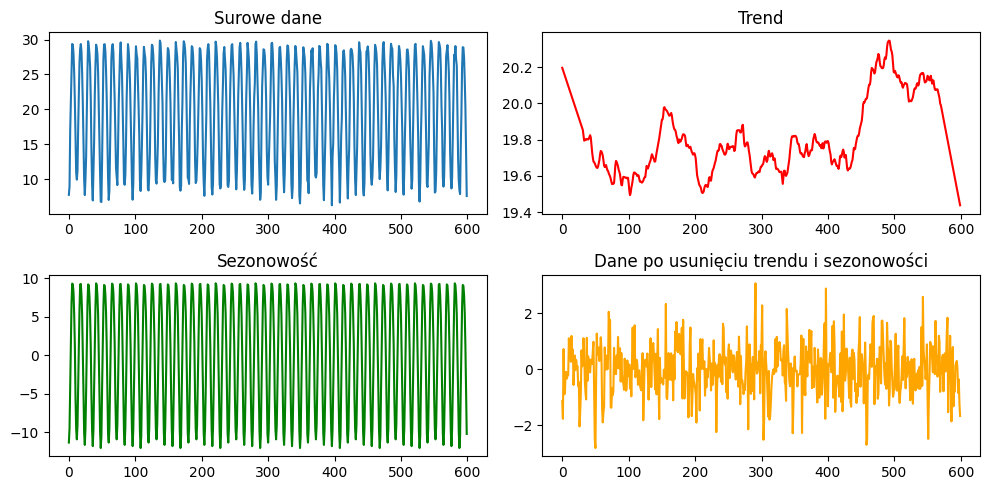

In [131]:
decomposition = seasonal_decompose(y, model='additive', period=60, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(y, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

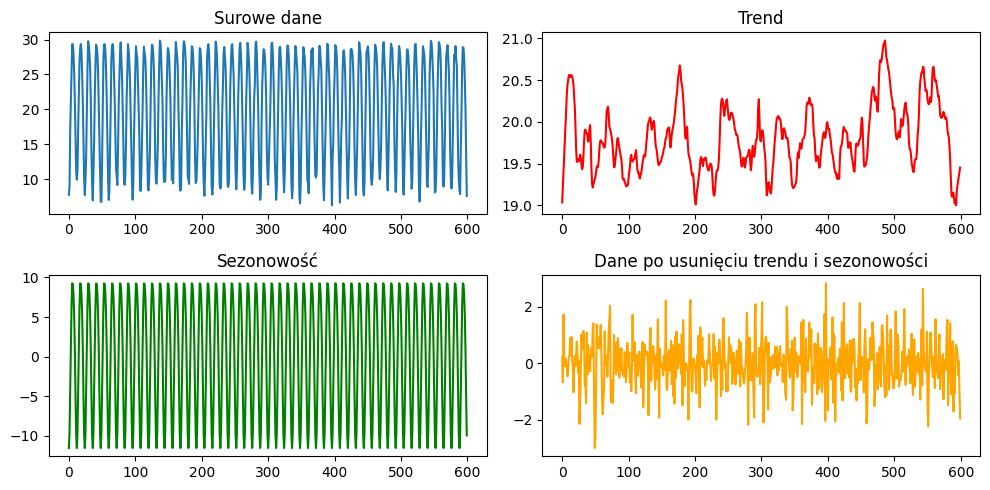

In [136]:
decomposition = seasonal_decompose(y, model='additive', period=12, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(y, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Trzecia metoda z laboratorium

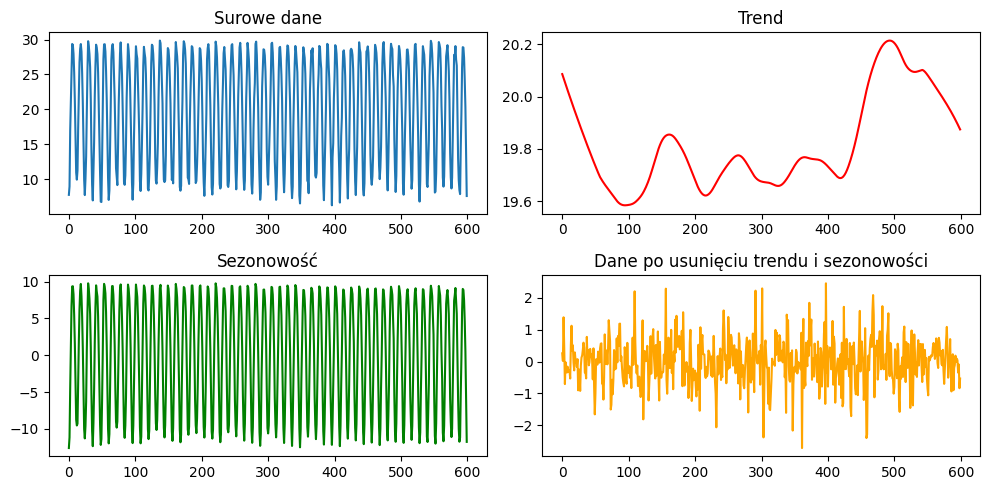

In [132]:
stl_decomposition = STL(y, period=60).fit()

trend_stl = stl_decomposition.trend
seasonal_stl = stl_decomposition.seasonal
residual_stl = stl_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(y, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_stl, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_stl, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_stl, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

# czwarte

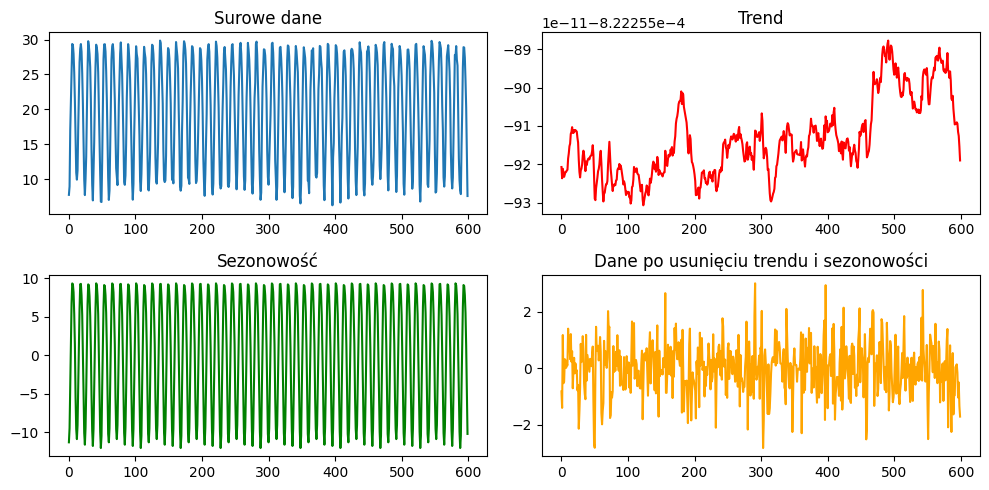

In [133]:
ets_model = ExponentialSmoothing(y, seasonal_periods=60, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(y, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

## ACF dla danych po usunięciu trendu i sezonowości

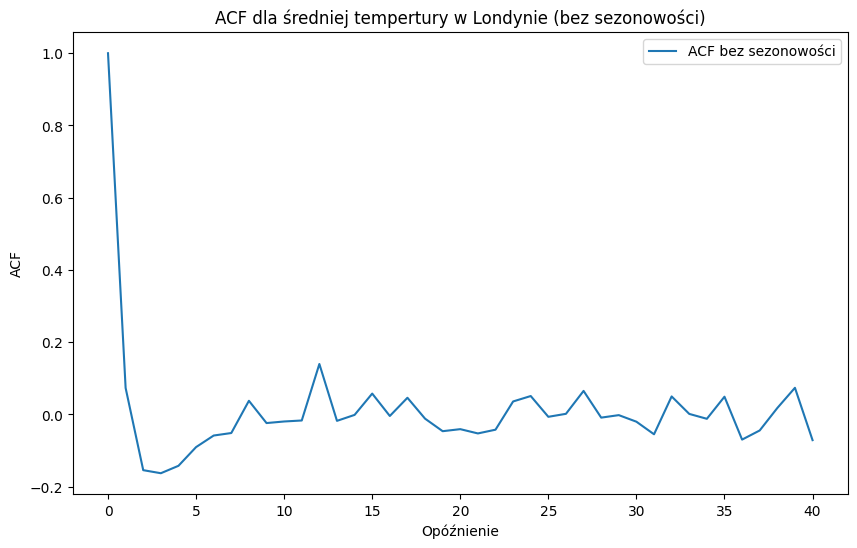

In [137]:
acf_without_seasonal = acf(residual, fft=True, nlags=h_max)

plt.figure(figsize=(10, 6))
plt.plot(acf_without_seasonal, label='ACF bez sezonowości')
plt.xlabel('Opóźnienie')
plt.ylabel('ACF')
plt.title('ACF dla średniej tempertury w Londynie (bez sezonowości)')
plt.legend()
plt.show()

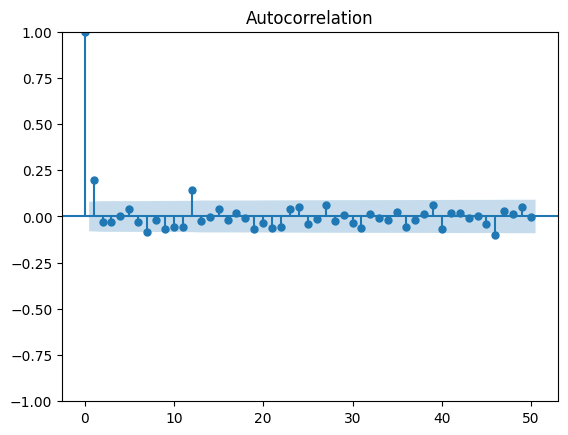

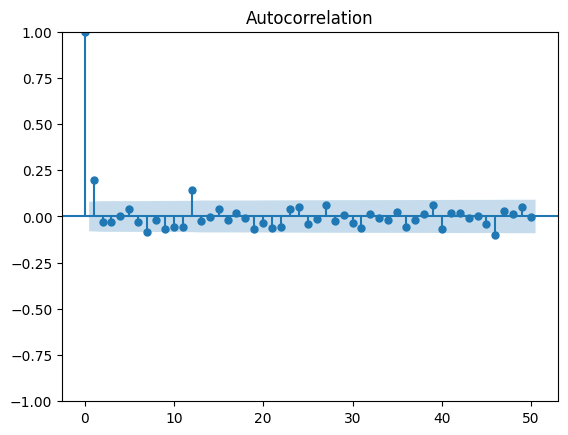

In [138]:
plot_acf(residual_ets, lags = 50)

## PACF dla danych po usunięciu trendu i sezonowości

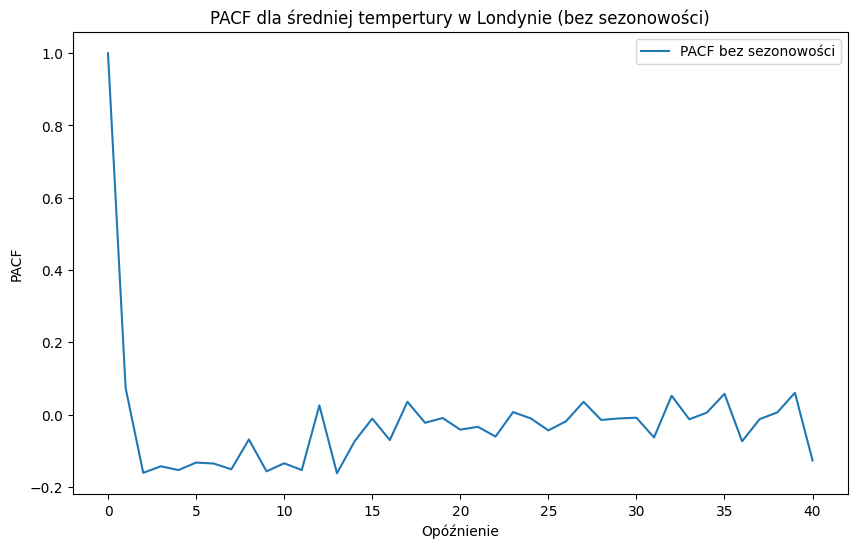

In [139]:
pacf_without_seasonal = pacf(residual, nlags=h_max, method='yw')
plt.figure(figsize=(10, 6))
plt.plot(pacf_without_seasonal, label='PACF bez sezonowości')
plt.xlabel('Opóźnienie')
plt.ylabel('PACF')
plt.title('PACF dla średniej tempertury w Londynie (bez sezonowości)')
plt.legend()
plt.show()

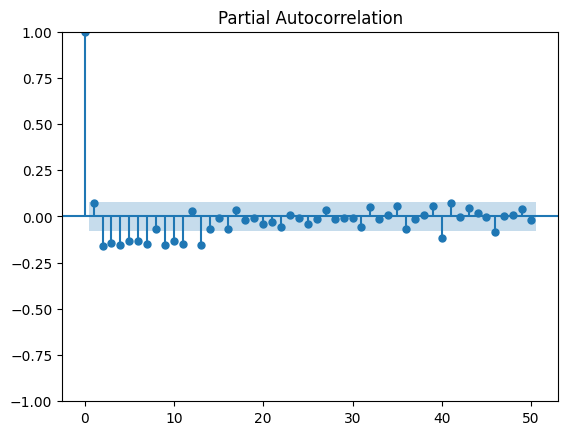

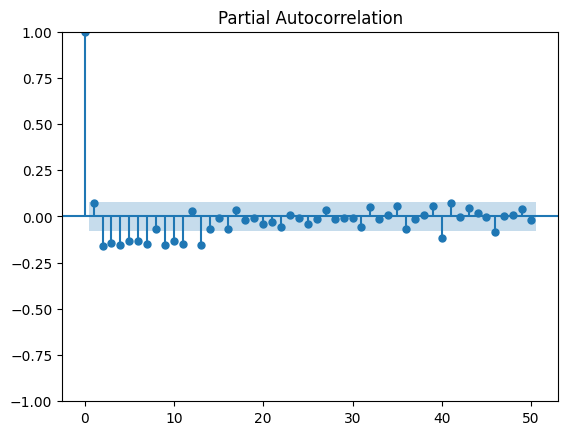

In [140]:
plot_pacf(residual, lags = 50)

## Takie trochę podsumowanie

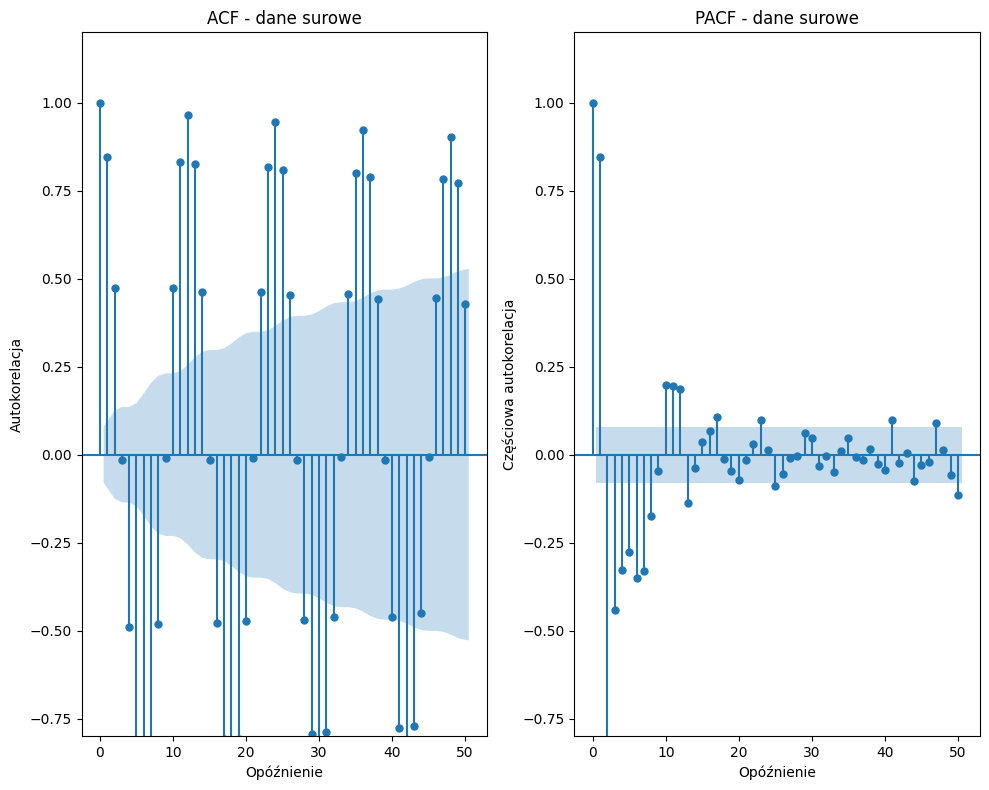

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

plot_acf(y, lags=50, ax=axes[0])
axes[0].set_xlabel('Opóźnienie')
axes[0].set_ylabel('Autokorelacja')
axes[0].set_title('ACF - dane surowe')
axes[0].set_ylim(-0.8, 1.2)

plot_pacf(y, lags=50, ax=axes[1])
axes[1].set_xlabel('Opóźnienie')
axes[1].set_ylabel('Częściowa autokorelacja')
axes[1].set_title('PACF - dane surowe')
axes[1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

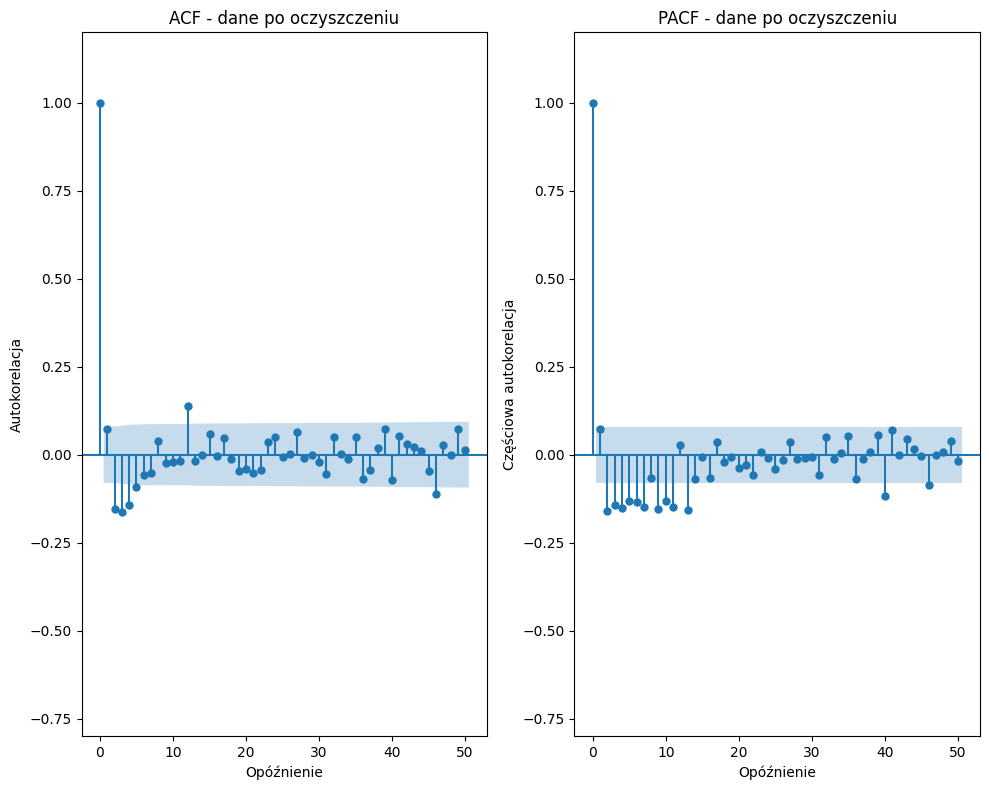

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

plot_acf(residual, lags=50, ax=axes[0])
axes[0].set_xlabel('Opóźnienie')
axes[0].set_ylabel('Autokorelacja')
axes[0].set_title('ACF - dane po oczyszczeniu')
axes[0].set_ylim(-0.8, 1.2)

plot_pacf(residual, lags=50, ax=axes[1])
axes[1].set_xlabel('Opóźnienie')
axes[1].set_ylabel('Częściowa autokorelacja')
axes[1].set_title('PACF - dane po oczyszczeniu')
axes[1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

# Test ADF dla danych surowych i dla danych po oczyszczeniu

In [115]:
def perform_adf_test(series):
    result = adfuller(series,autolag = 'AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [116]:
perform_adf_test(y)
# ADF Test dla surowych danych

ADF Statistic: -5.152563
p-value: 0.000011


In [117]:
perform_adf_test(residual)
# ADF Test dla danych po oczyszczeniu

ADF Statistic: -11.280429
p-value: 0.000000


In [180]:
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 3
max_q = 3

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(residual, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

In [181]:
print(df.sort_values(by='AIC').head(1))
print(df.sort_values(by='BIC').head(1))
print(df.sort_values(by='HQIC').head(1))

   p  q          AIC          BIC         HQIC
8  2  2  1351.676965  1378.058542  1361.946782
   p  q          AIC          BIC         HQIC
8  2  2  1351.676965  1378.058542  1361.946782
   p  q          AIC          BIC         HQIC
8  2  2  1351.676965  1378.058542  1361.946782


In [174]:
model3 = pm.auto_arima(residual, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=2, 
                       max_q=2, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = False)

print(model3.summary())

C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1507.932, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1505.369, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1506.683, Time=0.02 sec


C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec


C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1492.913, Time=0.04 sec


C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec


C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.84 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 2.161 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  600
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -743.457
Date:                Wed, 29 Jan 2025   AIC                           1492.913
Time:                        20:42:09   BIC                           1506.104
Sample:                             0   HQIC                          1498.048
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0851      0.032      2.656      0.008       0.022      

### Estymacja parametrów

In [192]:
p, q = 2,2

model_first_method = ARIMA(residual, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(residual, order=(p, 0, q)).fit(method='innovations_mle')
#model_third_method = ARIMA(residual, order=(p, 0, q)).fit(method='hannan_rissanen')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())
print("\n")
#print("Wyniki dla method='hannan_rissanen':\n")
#print(model_third_method.summary())

# wykomentowałem HR, ponieważ nie chciało się skompilować dla tej metody

C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  600
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -669.838
Date:                Wed, 29 Jan 2025   AIC                           1351.677
Time:                        20:54:29   BIC                           1378.059
Sample:                             0   HQIC                          1361.947
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.462      0.644      -0.001       0.002
ar.L1          1.4464      0.055     26.386      0.000       1.339       1.554
ar.L2         -0.69

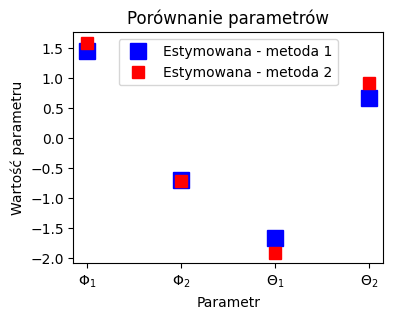

In [193]:
plt.figure(figsize=(4,3))

#plt.plot([p1, p2, q1, q2], 'o', markersize=10, alpha=0.5, label='Prawdziwa')
plt.plot(model_first_method.params[1:-1], 's', c = 'b', markersize=12, alpha=1, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', c = 'r', markersize=8, alpha=1, label='Estymowana - metoda 2')
#plt.plot(model_third_method.params[1:-1], 's', c = 'g', markersize=6, alpha=1, label='Estymowana - metoda 3')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')
# Dodawanie etykiet na osi X
param_names = ['$\Phi_1$', '$\Phi_2$','$\Theta_1$', '$\Theta_2$']  # Podpisy parametrów (dostosuj do danych)
plt.xticks(ticks=range(len(param_names)), labels=param_names)
#plt.xticks(ticks = 2, ['$\phi_1$', '$\Theta_1$'])

plt.show()

In [186]:
print(model_first_method.params[1:-1])

ar.L1    1.446383
ar.L2   -0.699206
ma.L1   -1.656966
ma.L2    0.663481
dtype: float64


In [187]:
print(model_second_method.params[1:-1])

ar.L1    1.579065
ar.L2   -0.716155
ma.L1   -1.907146
ma.L2    0.907521
dtype: float64


Musimy przyjąć jakieś parametry dla ARMA, nawet jeśli są "rozjazdy" w estymowaniu parametrów dla MA. Wobec tego przyjmiemy za parametry średnią arytmetyczną z obu metod (czy tak jest poprawnie? Pojęcia nie mam).

In [204]:
print(f"Parametry fi1 i fi2 wyznaczone z pierwszej metody: {model_first_method.arparams}")
print(f"Parametry theta1 i theta2 wyznaczone z pierwszej metody: {model_first_method.maparams}")
print()
print(f"Parametry fi1 i fi2 wyznaczone z drugiej metody: {model_second_method.arparams}")
print(f"Parametry theta1 i theta2 wyznaczone z drugiej metody: {model_second_method.maparams}")

Parametry fi1 i fi2 wyznaczone z pierwszej metody: [ 1.44638317 -0.6992062 ]
Parametry theta1 i theta2 wyznaczone z pierwszej metody: [-1.65696588  0.66348107]

Parametry fi1 i fi2 wyznaczone z drugiej metody: [ 1.57906535 -0.71615544]
Parametry theta1 i theta2 wyznaczone z drugiej metody: [-1.90714624  0.90752093]


In [228]:
phi1_estimated = (model_first_method.arparams[0] + model_second_method.arparams[0])/2
print(f"Parametr fi1, którego będziemy używać: {phi1_estimated}")

phi2_estimated = (model_first_method.arparams[1] + model_second_method.arparams[1])/2
print(f"Parametr fi2, którego będziemy używać: {phi2_estimated}")

theta1_estimated = (model_first_method.maparams[0] + model_second_method.maparams[0])/2
print(f"Parametr theta1, którego będziemy używać: {theta1_estimated}")

theta2_estimated = (model_first_method.maparams[1] + model_second_method.maparams[1])/2
print(f"Parametr theta2, którego będziemy używać: {theta2_estimated}")

sigma2_estimated = (model_first_method.params[5] + model_second_method.params[5])/2
print(f"Parametr sigma_kwadrat, którego będziemy używać: {sigma2_estimated}")

Parametr fi1, którego będziemy używać: 1.5127242582203624
Parametr fi2, którego będziemy używać: -0.7076808196311304
Parametr theta1, którego będziemy używać: -1.782056063841814
Parametr theta2, którego będziemy używać: 0.7855009966449382
Parametr sigma_kwadrat, którego będziemy używać: 0.5334797663748335


### Sprawdźmy, czy wielomiany nie mają wspólnych pierwiastków (inaczej nici z modelu ARMA)

In [231]:
ar_coefs = np.array([1, -phi1_estimated, -phi2_estimated])
ma_coefs = np.array([1, theta1_estimated, theta2_estimated])

arma22_process = ArmaProcess(ar_coefs, ma_coefs)

print("Pierwistki wielomianu AR:", arma22_process.arroots)

print("Pierwistki wielomianu MA:", arma22_process.maroots)

Pierwistki wielomianu AR: [1.06878992-0.52034077j 1.06878992+0.52034077j]
Pierwistki wielomianu MA: [1.01745668 1.25123053]


Nie mają wspólnych pierwiastków - dobra nasza!

#### Sprawdźmy, czy dobrany przez nas model ARMA(2;2) jest przyczynowy i odwracalny


In [232]:
print("Czy model przyczynowy?", arma22_process.isstationary)

print("Czy model odwracalny?", arma22_process.isinvertible)

Czy model przyczynowy? True
Czy model odwracalny? True


Jest przyczynowy i odwracalny - jupiiiiii ＼(￣▽￣)／

## 3. Ocena dopasowania modelu

### Przedziały ufności ACF

### Skoro mamy już parametry dla naszego modelu, możemy wyznaczyć teoretczne ACF i PACF

## Teoretyczne i empiryczne ACF

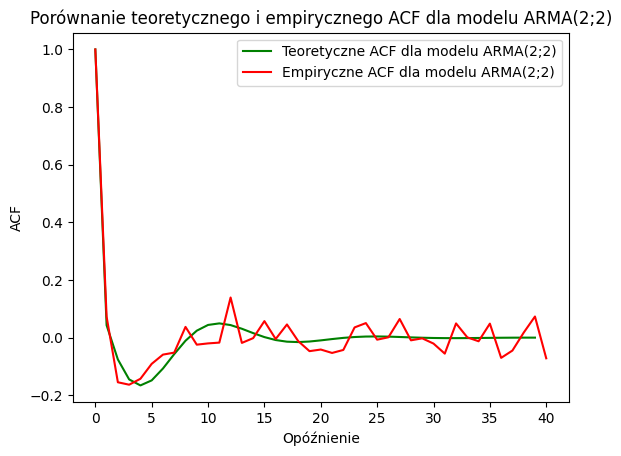

In [248]:
acf_teor = arma_acf(ar_coefs, ma_coefs, lags=h_max)
acf_empirical = acf(residual, fft=True, nlags=h_max)
plt.plot(acf_teor, c = 'g', label = 'Teoretyczne ACF dla modelu ARMA(2;2)')
plt.plot(acf_empirical, c ='r', label = 'Empiryczne ACF dla modelu ARMA(2;2)')
plt.legend()
plt.xlabel('Opóźnienie')
plt.ylabel('ACF')
plt.title('Porównanie teoretycznego i empirycznego ACF dla modelu ARMA(2;2)')
plt.show()


Jak one pięknie się pokrywają, aż się popłakałem ze wzruszenia

cudowne, jakby mnie kto miodem i mlekiem oblewał

ʚ(꒦ິ ꒳꒦ີ )ɞ♡

## Teoretyczne i empiryczne PACF

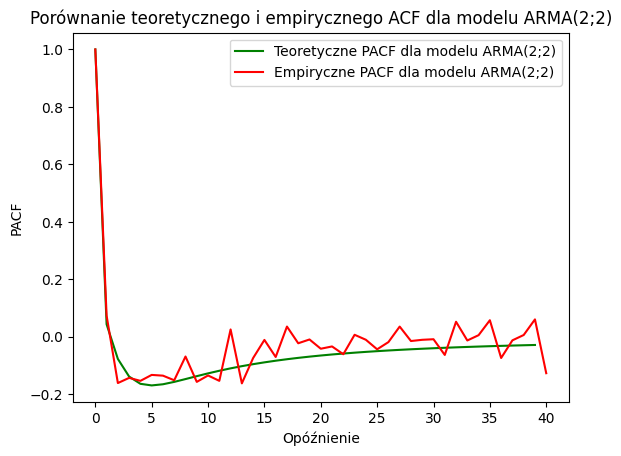

In [250]:
pacf_teor = arma_pacf(ar_coefs, ma_coefs, lags=h_max)
pacf_empirical = pacf(residual, nlags=h_max)
plt.plot(pacf_teor, c = 'g', label = 'Teoretyczne PACF dla modelu ARMA(2;2)')
plt.plot(pacf_empirical, c ='r', label = 'Empiryczne PACF dla modelu ARMA(2;2)')
plt.legend()
plt.xlabel('Opóźnienie')
plt.ylabel('PACF')
plt.title('Porównanie teoretycznego i empirycznego ACF dla modelu ARMA(2;2)')
plt.show()

Zaróno ACF i PACF mają taką "dupę" dla lagów między 0 a 5 - nie mam pojęcia, jakie wnioski można z tego wyciągnąć.

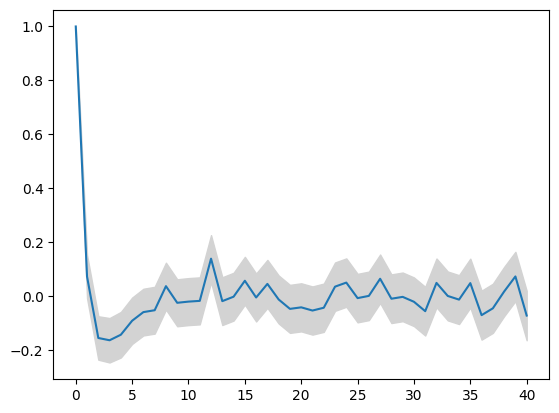

In [300]:
lags = np.arange(41)
# Obliczanie ACF z przedziałami ufności (domyślnie 95% przedziały)
acf_values, confint_values = acf(residual, alpha=0.05, fft=True, nlags = 40)

# Wydrukowanie wyników
#print("Autokorelacje:", acf_values)
#print()
#print("Przedziały ufności (95%):", confint_values)
#print(confint_values)

lewo1 = np.zeros(41)
prawo1 = np.zeros(41)

for i in range(len(lewo1)):
    lewo1[i] = confint_values[i][0]
    prawo1[i] = confint_values[i][1]

plt.fill_between(lags, lewo1, prawo1, color = 'lightgray')
plt.plot(acf_empirical)

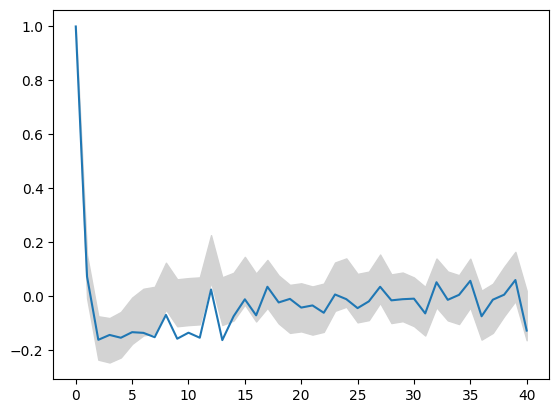

In [304]:
pacf_values, confint_values_pacf = acf(residual, alpha=0.05, fft=True, nlags = 40)

# Wydrukowanie wyników
#print("Autokorelacje:", acf_values)
#print()
#print("Przedziały ufności (95%):", confint_values)
#print(confint_values)

# acf_conf_intervals = np.percentile(acf_empirical, [5,95])
# plt.fill_between(lags, acf_conf_intervals[0], acf_conf_intervals[1], color = 'lightgray')
# plt.plot(acf_empirical)

lewo = np.zeros(41)
prawo = np.zeros(41)

for i in range(len(lewo)):
    lewo[i] = confint_values_pacf[i][0]
    prawo[i] = confint_values_pacf[i][1]

plt.fill_between(lags, lewo, prawo, color = 'lightgray')
plt.plot(pacf_empirical)

## !!! Zrobić countery dla ACF i PACF !!!

### Linie kwantylowe

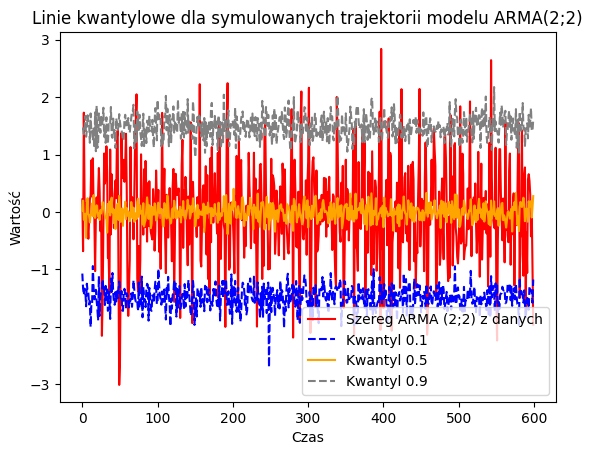

In [331]:
# Ustawiamy ziarno dla powtarzalności wyników

np.random.seed(41)

# Generowanie przykładowej trajektorii o długości 1000

num_trajectories = 100
num_points = 600
trajectories = np.zeros((num_trajectories, num_points))
# Domyślnie szum jest generowany z rozkładu normalnego
for i in range(num_trajectories):
    # Model ARMA(2,2)
    arma_process_simulated = ArmaProcess(ar_coefs, ma_coefs)
    trajectories[i, :] = arma_process_simulated.generate_sample(nsample=num_points)

quantiles_01 = np.quantile(trajectories, 0.1, axis=0)  # Kwantyl 10%
quantiles_02 = np.quantile(trajectories, 0.2, axis=0)  # Kwantyl 20%
quantiles_03 = np.quantile(trajectories, 0.3, axis=0)  # Kwantyl 30%
quantiles_04 = np.quantile(trajectories, 0.4, axis=0)  # Kwantyl 40%
quantiles_05 = np.quantile(trajectories, 0.5, axis=0)  # Kwantyl 50%
quantiles_06 = np.quantile(trajectories, 0.6, axis=0)  # Kwantyl 60%
quantiles_07 = np.quantile(trajectories, 0.7, axis=0)  # Kwantyl 70%
quantiles_08 = np.quantile(trajectories, 0.8, axis=0)  # Kwantyl 80%
quantiles_09 = np.quantile(trajectories, 0.9, axis=0)  # Kwantyl 90%
#arma_process_trajectory = arma_process.generate_sample(nsample = traj_size, scale = sigma)

time = np.arange(num_points)
plt.plot(residual, label = 'Szereg ARMA (2;2) z danych', color = 'red')
# Rysowanie kwantyli
plt.plot(time, quantiles_01, label='Kwantyl 0.1', color='blue', linestyle='--')
#plt.plot(time, quantiles_02, label='20% quantile', color='black', linestyle='-')
#plt.plot(time, quantiles_03, label='30% quantile', color='red', linestyle='--')
#plt.plot(time, quantiles_04, label='40% quantile', color='yellow', linestyle='--')
plt.plot(time, quantiles_05, label='Kwantyl 0.5', color='orange', linestyle='-')
#plt.plot(time, quantiles_06, label='60% quantile', color='green', linestyle='--')
#plt.plot(time, quantiles_07, label='70% quantile', color='magenta', linestyle='--')
#plt.plot(time, quantiles_08, label='80% quantile', color='cyan', linestyle='-')
plt.plot(time, quantiles_09, label='Kwantyl 0.9', color='gray', linestyle='--')

# Dodajemy tytuł, legendę i etykiety
plt.title('Linie kwantylowe dla symulowanych trajektorii modelu ARMA(2;2)')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.legend()
plt.show()


### Teoretyczne ACF dla modelu ARMA(1,1)

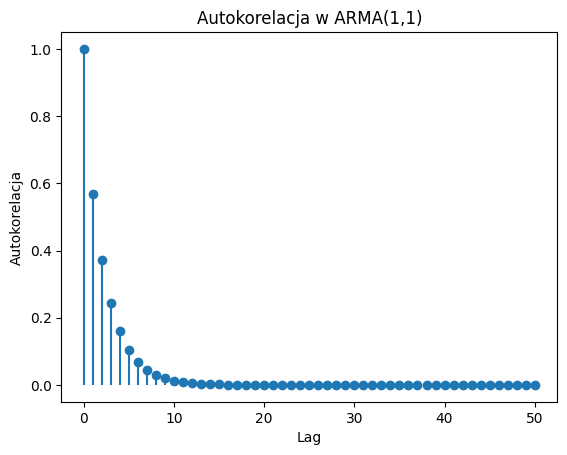

In [109]:
import numpy as np

# Parametry modelu ARMA(1,1)
phi = 0.654691  # współczynnik AR
theta = 0.200254  # współczynnik MA
sigma2 = 1.6885  # wariancja szumu
lags = 50  # liczba lagów

# Autokorelacje
rho = [1]  # Autokorelacja dla k=0
rho_1 = phi * (1 + phi * theta) / (1 + theta**2 + 2 * phi * theta)
rho.append(rho_1)

for k in range(2, lags + 1):
    rho_k = phi * rho[-1]  # Rekurencyjny wzór na rho_k
    rho.append(rho_k)

# Wykres autokorelacji
import matplotlib.pyplot as plt

plt.stem(range(lags + 1), rho, basefmt=" ")
plt.title("Autokorelacja w ARMA(1,1)")
plt.xlabel("Lag")
plt.ylabel("Autokorelacja")
plt.show()


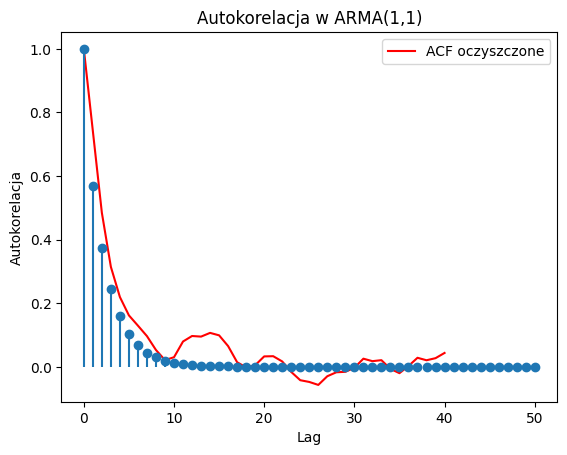

In [110]:
# Parametry modelu ARMA(1,1)
phi = 0.654691  # współczynnik AR
theta = 0.200254  # współczynnik MA
sigma2 = 1.6885  # wariancja szumu
lags = 50  # liczba lagów

# Autokorelacje
rho = [1]  # Autokorelacja dla k=0
rho_1 = phi * (1 + phi * theta) / (1 + theta**2 + 2 * phi * theta)
rho.append(rho_1)

for k in range(2, lags + 1):
    rho_k = phi * rho[-1]  # Rekurencyjny wzór na rho_k
    rho.append(rho_k)

# Wykres autokorelacji
import matplotlib.pyplot as plt

plt.plot(acf_without_seasonal, c = 'r', label='ACF oczyszczone')
plt.stem(range(lags + 1), rho, basefmt=" ")
plt.title("Autokorelacja w ARMA(1,1)")
plt.xlabel("Lag")
plt.ylabel("Autokorelacja")
plt.legend()
plt.show()


### Teoretyczne PACF dla modelu ARMA(1,1)

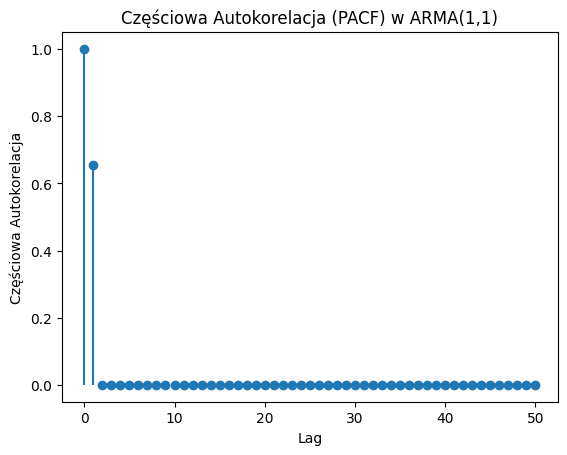

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry modelu ARMA(1,1)
phi = 0.654691  # współczynnik AR
theta = 0.200254  # współczynnik MA
lags = 50  # liczba lagów

# PACF
pacf = [1]  # PACF dla lag 0 wynosi zawsze 1
pacf_1 = phi  # PACF dla lag 1
pacf.append(pacf_1)

# PACF dla k >= 2 w ARMA(1,1) jest teoretycznie 0
for k in range(2, lags + 1):
    pacf.append(0)  # dla ARMA(1,1) PACF jest 0 dla lagów >= 2

# Wykres PACF
plt.stem(range(lags + 1), pacf, basefmt=" ")
plt.title("Częściowa Autokorelacja (PACF) w ARMA(1,1)")
plt.xlabel("Lag")
plt.ylabel("Częściowa Autokorelacja")
plt.show()


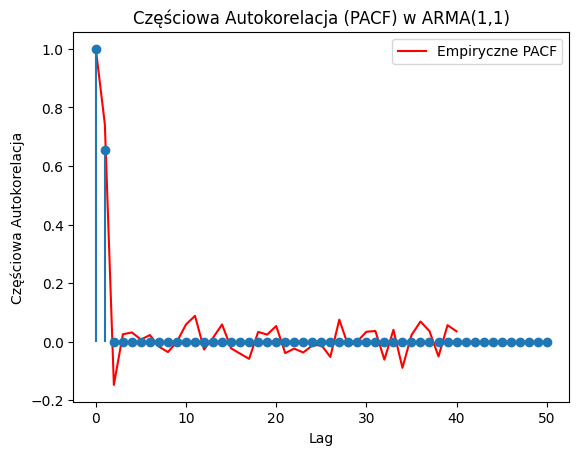

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry modelu ARMA(1,1)
phi = 0.654691  # współczynnik AR
theta = 0.200254  # współczynnik MA
lags = 50  # liczba lagów

# PACF
pacf = [1]  # PACF dla lag 0 wynosi zawsze 1
pacf_1 = phi  # PACF dla lag 1
pacf.append(pacf_1)

# PACF dla k >= 2 w ARMA(1,1) jest teoretycznie 0
for k in range(2, lags + 1):
    pacf.append(0)  # dla ARMA(1,1) PACF jest 0 dla lagów >= 2

# Wykres PACF
plt.plot(pacf_without_seasonal, c = 'r', label='Empiryczne PACF')
plt.stem(range(lags + 1), pacf, basefmt=" ")
plt.title("Częściowa Autokorelacja (PACF) w ARMA(1,1)")
plt.xlabel("Lag")
plt.ylabel("Częściowa Autokorelacja")
plt.legend()
plt.show()

### Linie kwantylowe

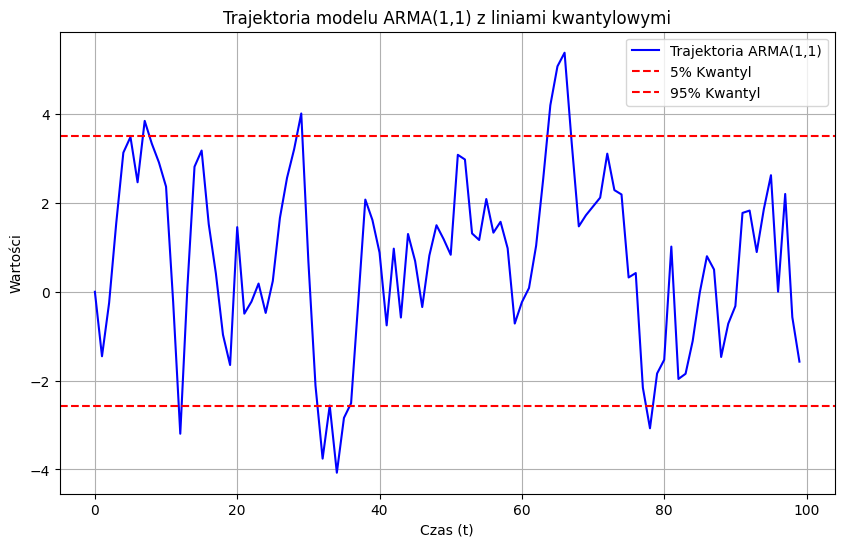

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry modelu ARMA(1,1)
phi = 0.654691  # współczynnik AR
theta = 0.200254  # współczynnik MA
sigma = np.sqrt(1.6885)  # odchylenie standardowe szumu (sqrt wariancji)
n = 100  # liczba obserwacji

# Inicjalizacja szeregu czasowego
w = np.zeros(n)
e = np.random.normal(0, sigma, n)  # generowanie białego szumu

# Generowanie procesu ARMA(1,1)
for t in range(1, n):
    w[t] = phi * w[t-1] + e[t] + theta * e[t-1]

# Obliczanie wartości kwantylowych (np. 5% i 95%)
lower_quantile = np.percentile(w, 5)
upper_quantile = np.percentile(w, 95)

# Rysowanie wykresu trajektorii
plt.figure(figsize=(10, 6))
plt.plot(w, label="Trajektoria ARMA(1,1)", color="b")
plt.axhline(y=lower_quantile, color='r', linestyle='--', label="5% Kwantyl")
plt.axhline(y=upper_quantile, color='r', linestyle='--', label="95% Kwantyl")
plt.title("Trajektoria modelu ARMA(1,1) z liniami kwantylowymi")
plt.xlabel("Czas (t)")
plt.ylabel("Wartości")
plt.legend()
plt.grid(True)
plt.show()


# Szybkie sprawdzenie pierwiastków, odwracalności, przyczynowości

In [45]:
ar_coef = np.array([1, phi])
ma_coef = np.array([1, theta])

arma_proc = ArmaProcess(ar_coef, ma_coef)

In [54]:
print("Pierwistki wielomianu AR:", arma_proc.arroots)

print("Pierwistki wielomianu MA:", arma_proc.maroots)

print("Czy model jest przyczynowy?", arma_proc.isstationary)

print("Czy model jest odwracalny?", arma_proc.isinvertible)

Pierwistki wielomianu AR: [-1.52743813]
Pierwistki wielomianu MA: [-4.99365805]
Czy model jest przyczynowy? True
Czy model jest odwracalny? True


# Residua

In [305]:
szum_fm = model_first_method.resid

szum_sm = model_second_method.resid

#szum_tm = model_third_method.resid

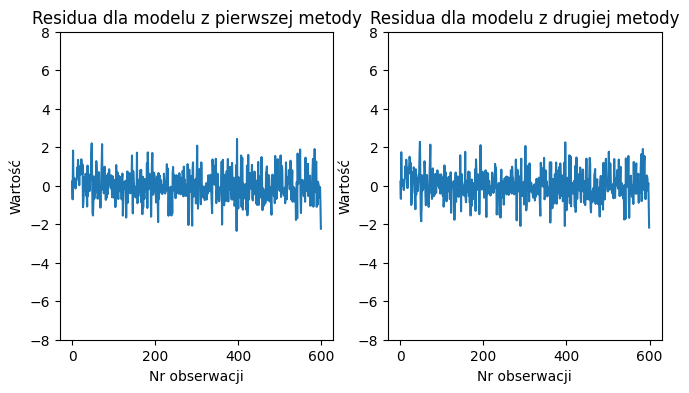

In [332]:
# Plot the residuals
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(szum_fm)
plt.title('Residua dla modelu z pierwszej metody')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

plt.subplot(1, 3, 2)
plt.plot(szum_sm)
plt.title('Residua dla modelu z drugiej metody')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-8, 8])

# plt.subplot(1, 3, 3)
# plt.plot(szum_tm)
# plt.title('Residua dla modelu z trzeciej metody')
# plt.xlabel('Nr obserwacji')
# plt.ylabel('Wartość')
# plt.ylim([-8, 8])

plt.show()

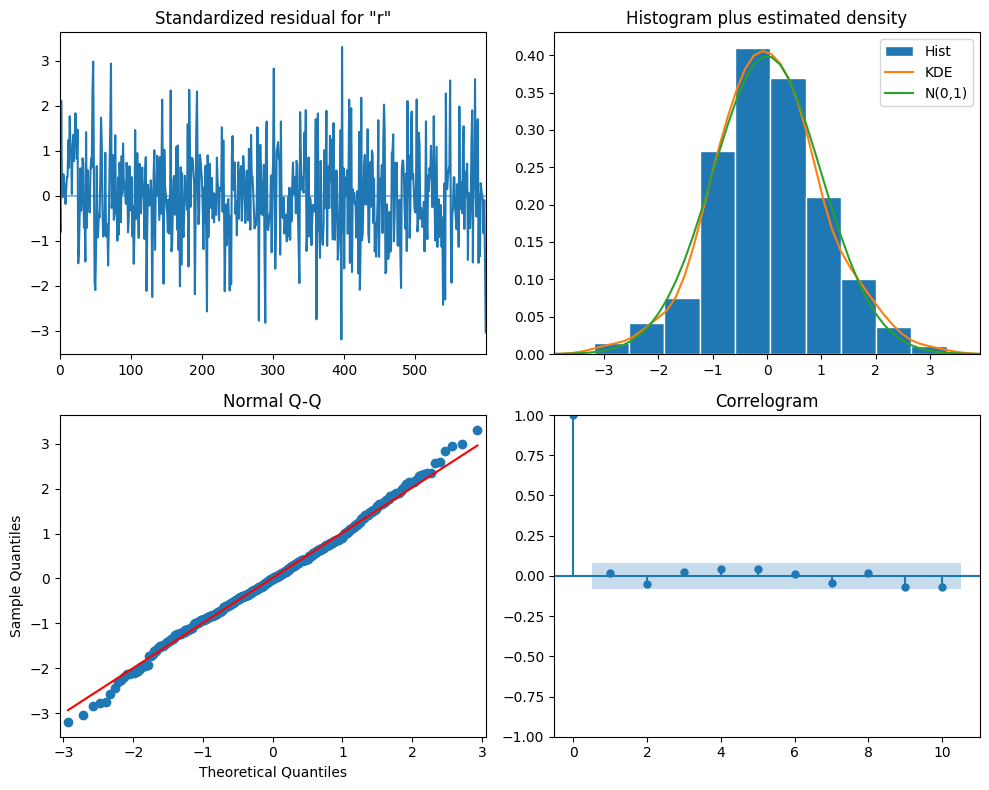

In [307]:
model_first_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

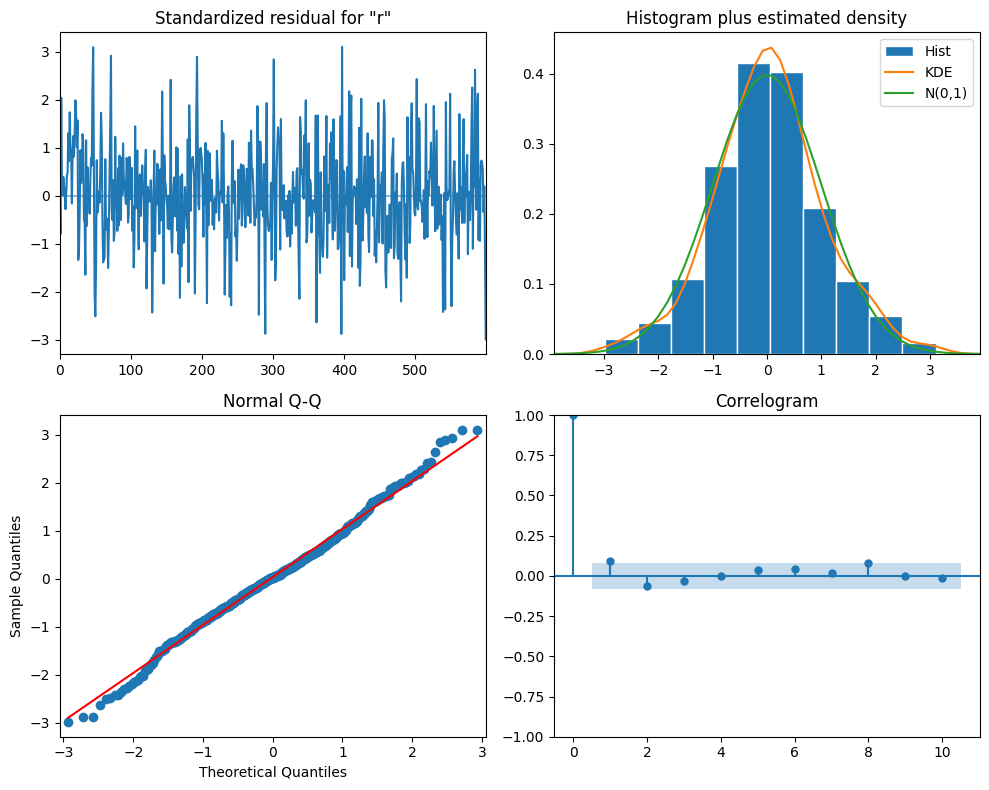

In [308]:
model_second_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

# Porównanie ACF i PACF dla modelu ARMA z szumem z rozkładu t-Studenta

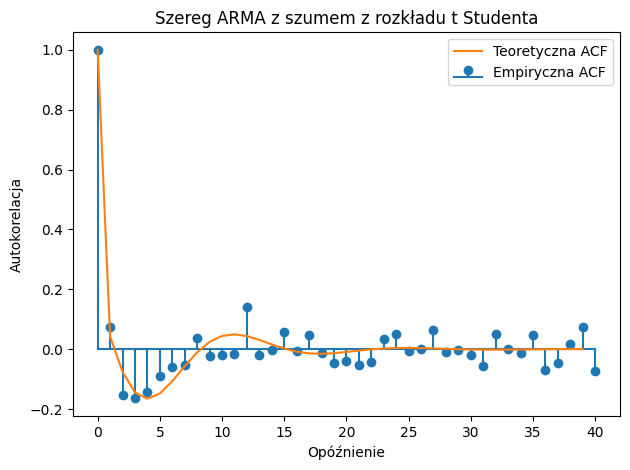

In [310]:
acf_teor_t = arma_acf(ar_coefs, ma_coefs, lags=h_max)
acf_emp_t = acf(residual, fft=False, nlags=h_max)

plt.stem(acf_emp_t, basefmt='', label='Empiryczna ACF')
plt.plot(acf_teor_t, '-', label='Teoretyczna ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()

plt.tight_layout()
plt.show()

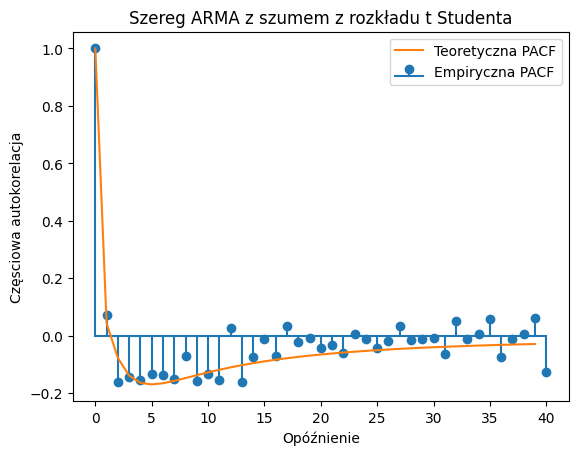

In [311]:
pacf_teor_t = arma_pacf(ar_coefs, ma_coefs, lags=h_max)
pacf_emp_t = pacf(residual, nlags=h_max, method='yw')

plt.stem(pacf_emp_t, basefmt='', label='Empiryczna PACF')
plt.plot(pacf_teor_t, '-', label='Teoretyczna PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Częsciowa autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()
plt.show()

# ACF i PACF dla wartości resztowych

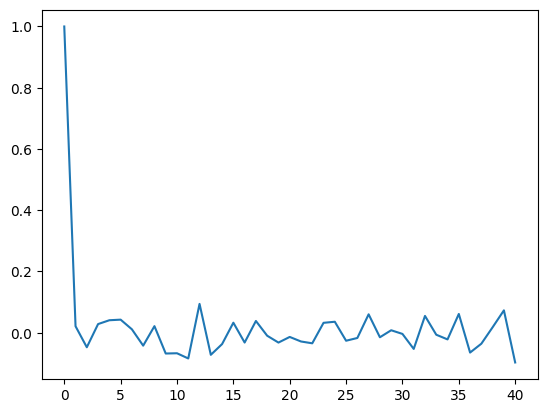

In [334]:
szum_fm_acf = acf(szum_fm, fft=True, nlags=h_max)
plt.plot(szum_fm_acf)
plt.show()
# dopisz legende, tytuł i osie

In [336]:
print(type(szum_fm))

<class 'pandas.core.series.Series'>


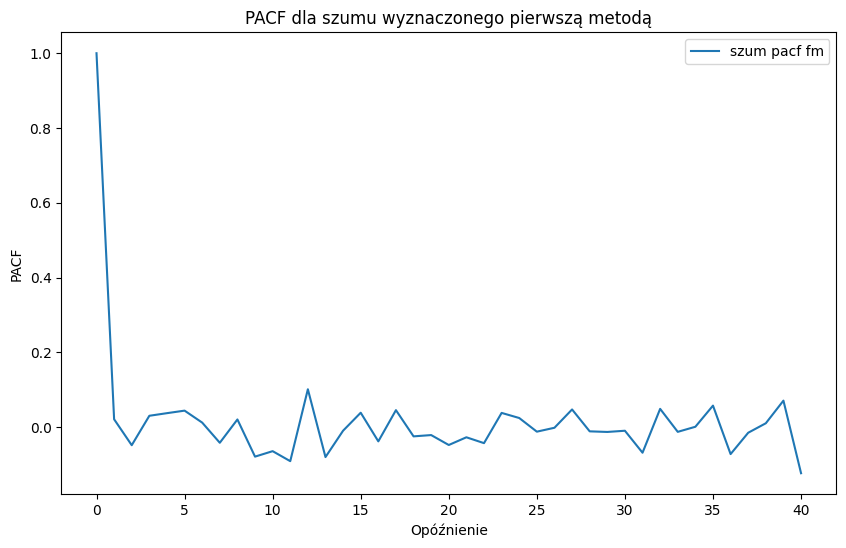

In [313]:
szum_fm_pacf = pacf(szum_fm, nlags=h_max, method='yw')
plt.figure(figsize=(10, 6))
plt.plot(szum_fm_pacf, label='szum pacf fm')
plt.xlabel('Opóźnienie')
plt.ylabel('PACF')
plt.title('PACF dla szumu wyznaczonego pierwszą metodą')
plt.legend()
plt.show()

### Oba wykresy są "na oko" dobre

# T-Test

In [316]:
arma_proc_trajectory = arma22_process.generate_sample(nsample = len(y), scale = sigma2_estimated)
generated_model = ARIMA(arma_proc_trajectory, order=(p, 0, q)).fit(method='statespace')
generated_model_szum = generated_model.resid

t_statistics1, ttest_p_wartosc1 = stats.ttest_ind(szum_fm, generated_model_szum)
print(f'Statystyka T (1): {t_statistics1}')
print(f'p-value (1): {ttest_p_wartosc1}')

t_statistics2, ttest_p_wartosc2 = stats.ttest_ind(szum_sm, generated_model_szum)
print(f'Statystyka T (2): {t_statistics2}')
print(f'p-value (2): {ttest_p_wartosc2}')

# t_statistics3, ttest_p_wartosc3 = stats.ttest_ind(szum_tm, generated_model_szum)
# print(f'Statystyka T (3): {t_statistics3}')
# print(f'p-value (3): {ttest_p_wartosc3}')

C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Statystyka T (1): -0.006786693998136402
p-value (1): 0.9945861731241283
Statystyka T (2): 0.3200080557747068
p-value (2): 0.7490180244441502


C:\Users\Janek\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Bardzo wysoka wartość p-value - brak "przypadkowości w szumie" ???

# Modified Levene Test / ARCH Test

### MLT

In [321]:
l_statistics1, ltest_p_wartosc1 = stats.levene(szum_fm, generated_model_szum)
print(f'Statystyka Levene (1): {l_statistics1}')
print(f'p-value (1): {ltest_p_wartosc1}\n')

l_statistics2, ltest_p_wartosc2 = stats.levene(szum_sm, generated_model_szum)
print(f'Statystyka Levene (2): {l_statistics2}')
print(f'p-value (2): {ltest_p_wartosc2}\n')

# l_statistics3, ltest_p_wartosc3 = stats.levene(szum_tm, generated_model_szum)
# print(f'Statystyka Levene (3): {l_statistics3}')
# print(f'p-value (3): {ltest_p_wartosc3}')

Statystyka Levene (1): 46.82826977479443
p-value (1): 1.233639809540879e-11

Statystyka Levene (2): 37.180777029396125
p-value (2): 1.450140173929041e-09



### ARCH

In [320]:
from statsmodels.stats.diagnostic import het_arch

lmstats1, lm_pvalue1, fstats1, f_pvalue1 = het_arch(szum_fm, nlags = 20, ddof = p+q)
print(f'Lagrange multiplier test statistic (1): {lmstats1}')
print(f'Lagrange multiplier p-value (1): {lm_pvalue1}')
print(f'F-Test statistics (1): {fstats1}')
print(f'F-Test p-value (1): {f_pvalue1}\n')

lmstats2, lm_pvalue2, fstats2, f_pvalue2 = het_arch(szum_sm, nlags = 20, ddof = p+q)
print(f'Lagrange multiplier test statistic (2): {lmstats2}')
print(f'Lagrange multiplier p-value (2): {lm_pvalue2}')
print(f'F-Test statistics (2): {fstats2}')
print(f'F-Test p-value (2): {f_pvalue2}\n')

# lmstats3, lm_pvalue3, fstats3, f_pvalue3 = het_arch(szum_tm, nlags = 20, ddof = p+q)
# print(f'Lagrange multiplier test statistic (3): {lmstats3}')
# print(f'Lagrange multiplier p-value (3): {lm_pvalue3}')
# print(f'F-Test statistics (3): {fstats3}')
# print(f'F-Test p-value (3): {f_pvalue3}\n')



Lagrange multiplier test statistic (1): 42.43409249953134
Lagrange multiplier p-value (1): 0.002426847671185185
F-Test statistics (1): 2.2228423306090996
F-Test p-value (1): 0.0017767389510001512

Lagrange multiplier test statistic (2): 47.8475333437529
Lagrange multiplier p-value (2): 0.0004468551080384438
F-Test statistics (2): 2.532106998239795
F-Test p-value (2): 0.0002833018460994203



# Ljung-Box Test

In [319]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lbtest_results = acorr_ljungbox(residual, model_df = p+q, period = 365)
print(lbtest_results)

        lb_stat     lb_pvalue
1      3.233156           NaN
2     17.630367           NaN
3     33.675197           NaN
4     45.951000           NaN
5     50.925276  9.595000e-13
..          ...           ...
116  172.768261  2.010000e-04
117  172.899845  2.476059e-04
118  174.524627  2.299562e-04
119  176.073558  2.166397e-04
120  176.086952  2.718150e-04

[120 rows x 2 columns]


# Dystrybuanta i gęstość rozkładu wartości resztowych

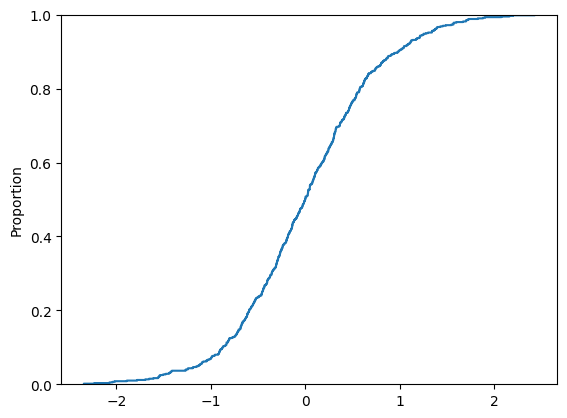

In [318]:
empirical_ecdf = sb.ecdfplot(szum_fm)

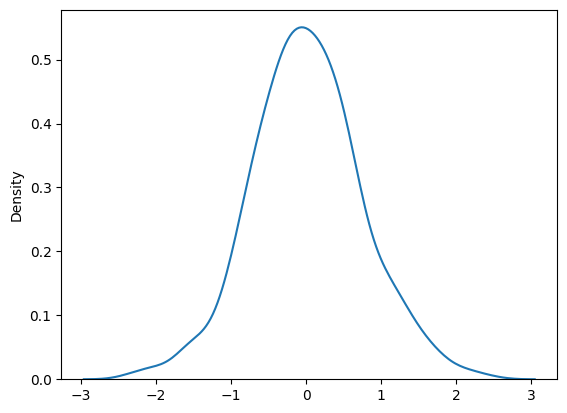

In [317]:
empirical_density = sb.kdeplot(szum_fm)

# Testy na normalność

### Kolmogorov-Smirnov test

In [66]:
from scipy.stats import kstest

kstest_result = kstest(szum_fm, 'norm', args = (-0.03474921404587797, 0.670806667830805))
print(kstest_result)

KstestResult(statistic=0.15466785261117244, pvalue=1.0247180247912102e-15, statistic_location=0.9552728017748642, statistic_sign=-1)


### Anderson-Darling Test

In [322]:
from scipy.stats import anderson

result = anderson(szum_fm, dist='norm')
print(f'Statystyka testu: {result.statistic}')
print(f'Krytyczne wartości: {result.critical_values}')

if result.statistic < result.critical_values[2]:
    print('Dane są zgodne z rozkładem normalnym')
else:
    print('Dane nie pochodzą z rozkładu normalnego')


Statystyka testu: 0.7136708643290604
Krytyczne wartości: [0.572 0.652 0.782 0.912 1.085]
Dane są zgodne z rozkładem normalnym
